In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

from keras import Sequential
from keras.layers import Dense

from PIL import Image
from time import time

from random import randint

from sklearn.preprocessing import LabelEncoder

# import os

Using TensorFlow backend.


# Import all data:
- __DATA_01/Images_01.npy__ : Images (2794, 224, 224, 3)
- __DATA_01/Labels_01.npy__ : Labels (2794, 1)

In [2]:
X_data = np.load('DATA_01/Images_01.npy')
y_data = np.load('DATA_01/Labels_01.npy')

print('X_data shape: %20s' % (str(X_data.shape)))
print('y_data shape: %20s' % (str(y_data.shape)))

X_data shape:  (2794, 224, 224, 3)
y_data shape:            (2794, 1)


In [74]:
classes_num = len(np.unique(y_data))
names, counts = np.unique(y_data, return_counts=True)

print(f'Found {len(X_data)} observations.')
print(f'Found {classes_num} unique classes.\n')
print('-'*48)
print('| %3s | %30s | %5s |' % ('IDX', 'LABEL', 'COUNT'))
print('-'*48)
for i, name in enumerate(names):
    print('| %3s | %30s | %5s |' % (i+1 , name, counts[i]))
print('-'*48)

Found 2794 observations.
Found 11 unique classes.

------------------------------------------------
| IDX |                          LABEL | COUNT |
------------------------------------------------
|   1 |                    apple_fruit |   248 |
|   2 |                  avocado_fruit |   249 |
|   3 |                         banana |   299 |
|   4 |             beetroot_vegetable |   250 |
|   5 |          bell_pepper_vegetable |   250 |
|   6 |             broccoli_vegetable |   250 |
|   7 |               carrot_vegetable |   249 |
|   8 |                    lemon_fruit |   250 |
|   9 |                   orange_fruit |   250 |
|  10 |            red_onion_vegetable |   250 |
|  11 |               strawberry_fruit |   249 |
------------------------------------------------


In [75]:
def print_images(images, labels, dim=(4, 4)):
    n = dim[0] * dim[1]
    
    assert len(images>=n) and len(images) == len(labels)
    
    indexes = []
    while len(indexes) < n:
        idx = randint(0, len(images))
        if idx not in indexes:
            indexes.append(idx)

    plt.figure(figsize=(10,10))
    
    for i, idx in enumerate(indexes):
        plt.subplot(dim[0], dim[1], i+1)
#         plt.subplots_adjust(hspace = 0.3)
        plt.imshow(images[idx])
        plt.title(labels[idx])
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

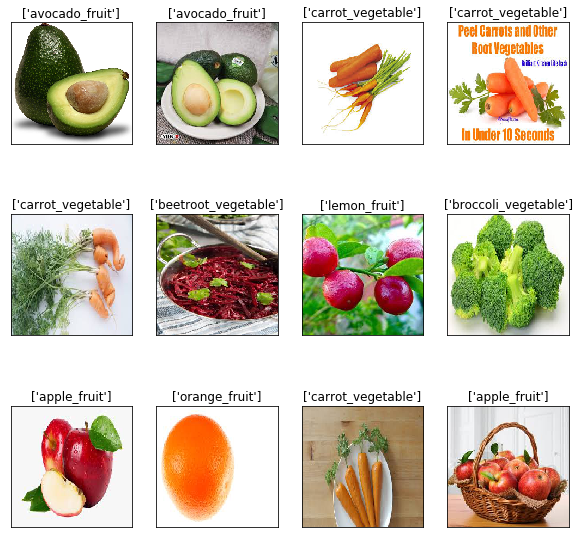

In [76]:
print_images(images=X_data,
             labels=y_data,
             dim=(3, 4))

### OneHotEncoder

In [77]:
# one_hot = pd.get_dummies(pd.Series(y_data.squeeze()))
# y_data_one_hot = one_hot.to_numpy()
# print('y_data_one_hot shape: %10s' % (str(y_data_one_hot.shape)))

y_data_one_hot shape: (2794, 11)


### LabelEncoder

In [79]:
le = LabelEncoder()

le.fit(y_data.squeeze())
y_data_encoded = le.transform(y_data.squeeze())

y_data_encoded = y_data_encoded.reshape(len(y_data_encoded), 1)

print('y_data_encoded shape: %10s' % (str(y_data_encoded.shape)))
print('\n', y_data_encoded[:4])

y_data_encoded shape:  (2794, 1)

 [[7]
 [7]
 [7]
 [7]]


# MobileNet model

- MobileNet has been trained on the ImageNet dataset
- Excpects image with shape (224, 224, 3)
- ImageNet has 1001 different output classes

In [87]:
def MobileNet(IMAGE_RES=224):
    '''
    Full MobileNet_v2 model ready for classification.
    INPUT_SHAPE = (224, 224, 3)
    OUTPUT_SHAPE = (1001, 1)
    '''
    
    URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

    MobileNet = tf.keras.Sequential([
        hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
    ])
    
    return MobileNet

In [88]:
MobileNet=MobileNet()
MobileNet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


### Get ImageNet's 1001 labels
- __ImageNet_labels.txt__ : Prepared txt file with all labels separated with '\n'
- You may find them online: https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [95]:
with open('ImageNet_labels.txt', 'r') as file:
    ImageNet_labels = file.read()
    ImageNet_labels = np.array(ImageNet_labels.split('\n')[:-1])

print(f'ImageNet_labels length: {len(ImageNet_labels)}')

ImageNet_labels length: 1001


### Predict

In [138]:
def predict(model, model_labels, single_image):
    '''
    Returns predicted label.
    Plot out image and top 3 most probable labels for provided image.
    '''
    
    print(f'Image shape: {single_image.shape}')
    
    # Requires batch > Create single image batch
    batch = single_image[np.newaxis, ...]
    print(f'ImageNet input final shape: {batch.shape}')
    
    # Make prediction
    prediction = MobileNet.predict(batch)
    print(f'ImageNet output final shape: {prediction.shape}')
    
    # Retrievie top 3 predicitons
    s = pd.Series(data=prediction.squeeze(),
                  index=model_labels)
    s = s.sort_values(ascending=False).iloc[:3]
    
    # Plot the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(single_image)
    plt.title(f'Prediction: {s.index[0]}')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(1, 2, 2)
    plt.bar(x=s.index, height=s.values, )
    plt.title('Top3 labels probabilities')
    
    plt.suptitle("ImageNet_v2 original prediction.")
    plt.plot()
    
    return s.index[0]

Image shape: (224, 224, 3)
ImageNet input final shape: (1, 224, 224, 3)
ImageNet output final shape: (1, 1001)


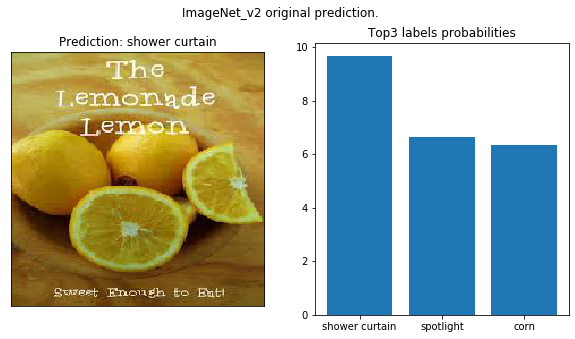

In [146]:
# Predict image file
label = predict(model=MobileNet,
                model_labels=ImageNet_labels,
                single_image=X_data[0])

# Transfer learning 
- mobilenet_v2 - feature_vector

In [147]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(224, 224,3))

# Do not want to change pre trained models weights
feature_extractor.trainable = False

### 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub

In [148]:
transferedModel = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(units=classes_num,
                 activation='softmax'),
])

transferedModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 11)                14091     
Total params: 2,272,075
Trainable params: 14,091
Non-trainable params: 2,257,984
_________________________________________________________________


### Compile

In [149]:
transferedModel.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [150]:
EPOCHS = 15

In [151]:
history = transferedModel.fit(x=X_data,
                              y=y_data_encoded,
                              epochs=EPOCHS,
                              validation_split=0.2,
                              verbose=1)

Train on 2235 samples, validate on 559 samples
Epoch 1/15
2235/2235 [==============================] - 87s 39ms/sample - loss: 2.2980 - accuracy: 0.2483 - val_loss: 2.4627 - val_accuracy: 0.0465
Epoch 2/15
2235/2235 [==============================] - 84s 38ms/sample - loss: 2.1762 - accuracy: 0.4089 - val_loss: 2.4550 - val_accuracy: 0.0662
Epoch 3/15
2235/2235 [==============================] - 87s 39ms/sample - loss: 2.1188 - accuracy: 0.4689 - val_loss: 2.4536 - val_accuracy: 0.0662
Epoch 4/15
2235/2235 [==============================] - 87s 39ms/sample - loss: 2.0670 - accuracy: 0.5280 - val_loss: 2.4455 - val_accuracy: 0.0716
Epoch 5/15
2235/2235 [==============================] - 74s 33ms/sample - loss: 2.0250 - accuracy: 0.5758 - val_loss: 2.4501 - val_accuracy: 0.0733
Epoch 6/15
2235/2235 [==============================] - 75s 34ms/sample - loss: 1.9960 - accuracy: 0.6103 - val_loss: 2.4520 - val_accuracy: 0.0680
Epoch 7/15
2235/2235 [==============================] - 74s 33ms/

### Plot the performance

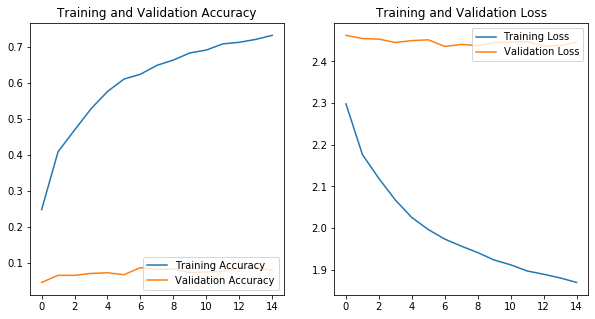

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [160]:
transferedModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 11)                14091     
Total params: 2,272,075
Trainable params: 14,091
Non-trainable params: 2,257,984
_________________________________________________________________


# TRAGIC PERFORMANCE..... val_accuracy: 0.0805?!